### Note

This Jupyter Notebook is used for presenting the backtesting results.

Please find the other four python files in the folder.

regime_hmm_train.py --- used for training the HMM model

conintegration.py --- used for testing the conintegration relationship

hmm_risk_manager.py --- HMM risk manager component

kalman_filter_strategy --- Kalman Filter Pairs Trading Strategy component


In [1]:
import click
import datetime
import pickle


from kalman_filter_strategy import KalmanFilterPairsTradingStrategy
from hmm_risk_manager import HMMRiskManager
from conintegration import get_adf_test_results


# QS trader
from qstrader import settings
from qstrader.compat import queue
from qstrader.price_parser import PriceParser
from qstrader.price_handler.yahoo_daily_csv_bar import YahooDailyCsvBarPriceHandler
from qstrader.position_sizer.naive import NaivePositionSizer 
from qstrader.risk_manager.example import ExampleRiskManager 
from qstrader.portfolio_handler import PortfolioHandler
from qstrader.compliance.example import ExampleCompliance 
from qstrader.execution_handler.ib_simulated import IBSimulatedExecutionHandler
from qstrader.statistics.tearsheet import TearsheetStatistics 
from qstrader.trading_session import TradingSession

### Conintegration Test 

In [2]:
start_date = datetime.datetime(2011, 4, 29)
end_date = datetime.datetime(2021, 4, 30)
x = 'data/UPRO.csv'
y = 'data/VOO.csv'
get_adf_test_results(x, y, start_date, end_date)
get_adf_test_results(y, x, start_date, end_date)

ADF Statistic: -3.184516
p-value: 0.020899
Significance level: 
	1%: -3.4329799947351503
	5%: -2.862701915447137
	10%: -2.5673885329713495
x and y are conintegrated!
ADF Statistic: -3.111863
p-value: 0.025688
Significance level: 
	1%: -3.4329799947351503
	5%: -2.862701915447137
	10%: -2.5673885329713495
x and y are conintegrated!


Since when x is UPRO and y is VOO the ADF test result is lower, we set the independent variable x as UPRO and the dependent variable y as VOO.

## Kalman Filter-Based Pairs Trading with the Hidden Markov Model

In [3]:
def run(config, testing, tickers, filename):

    # Set up variables needed for backtest
    pickle_path_1 = "/Users/xuhuili/Desktop/ST451_Bayesian_Machine_Learning/Project/model/hmm_model_upro.pkl"
    pickle_path_2 = "/Users/xuhuili/Desktop/ST451_Bayesian_Machine_Learning/Project/model/hmm_model_voo.pkl"
    events_queue = queue.Queue()
    csv_dir = config.CSV_DATA_DIR
    initial_equity = PriceParser.parse(100000.00)

    # Use Yahoo Daily Price Handler
    # Backtest period: April 30th, 2019 to April 30th, 2021 
    start_date = datetime.datetime(2019, 4, 30)
    end_date = datetime.datetime(2021, 4, 30)
    price_handler = YahooDailyCsvBarPriceHandler(csv_dir, events_queue, tickers, \
    start_date = start_date, end_date = end_date, calc_adj_returns=True)

    # Use the Kalman Filter Pairs Trading Strategy 
    strategy = KalmanFilterPairsTradingStrategy(tickers, events_queue)

    # Use the Naive Position Sizer
    position_sizer = NaivePositionSizer()

    # Use the Hidden Markov Model as a risk manager
    hmm_model_1 = pickle.load(open(pickle_path_1, "rb"))
    hmm_model_2 = pickle.load(open(pickle_path_2, "rb"))
    risk_manager = HMMRiskManager(hmm_model_1, hmm_model_2)

    # Use the default Portfolio Handler
    portfolio_handler = PortfolioHandler(
        initial_equity, events_queue, price_handler,
        position_sizer, risk_manager
    )

    # Use the ExampleCompliance component 
    compliance = ExampleCompliance(config)

    # Use a simulated IB Execution Handler 
    execution_handler = IBSimulatedExecutionHandler(
        events_queue, price_handler, compliance
    )

    # Use the default Statistics 
    statistics = TearsheetStatistics(
        config, portfolio_handler, title = ""
    )

    title = ['Kalman Filter-Based Pairs Trading with the Hidden Markov Model']
    backtest = TradingSession(config, strategy, tickers,
        initial_equity, start_date, end_date, events_queue, risk_manager = risk_manager, \
        price_handler = price_handler, portfolio_handler = portfolio_handler, \
            compliance = compliance, position_sizer = position_sizer, \
            execution_handler = execution_handler, statistics = statistics, \
            title = title)
    results = backtest.start_trading(testing = testing)
    statistics.save(filename = filename)
    return results

Running Backtest...
Short: 2019-05-02 00:00:00
Regime 0
Open
Regime 0
Open
CLOSING SHORT: 2019-05-03 00:00:00
Regime 0
Open
Regime 0
Open
Short: 2019-05-07 00:00:00
Regime 0
Open
Regime 0
Open
CLOSING SHORT: 2019-05-08 00:00:00
Regime 0
Open
Regime 0
Open
Short: 2019-05-13 00:00:00
Regime 0
Open
Regime 0
Open
CLOSING SHORT: 2019-05-14 00:00:00
Regime 0
Open
Regime 0
Open
LONG: 2019-06-04 00:00:00
Regime 1
Bad Market Condition, do not invest
Regime 1
Bad Market Condition, do not invest
CLOSING LONG: 2019-06-10 00:00:00
Regime 0
Open
Regime 0
Open
Short: 2019-08-05 00:00:00
Regime 0
Open
Regime 0
Open
CLOSING SHORT: 2019-08-06 00:00:00
Regime 0
Open
Regime 0
Open
LONG: 2019-08-08 00:00:00
Regime 1
Bad Market Condition, do not invest
Regime 1
Bad Market Condition, do not invest
CLOSING LONG: 2019-08-09 00:00:00
Regime 0
Open
Regime 0
Open
Short: 2019-08-14 00:00:00
Regime 0
Open
Regime 0
Open
CLOSING SHORT: 2019-08-15 00:00:00
Regime 0
Open
Regime 0
Open
Short: 2019-08-23 00:00:00
Regime 

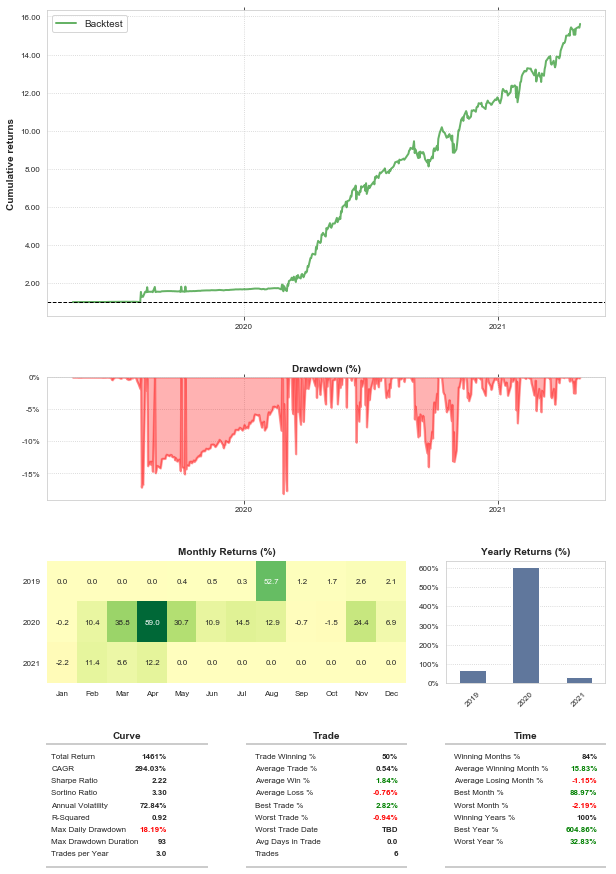

<Figure size 432x288 with 0 Axes>

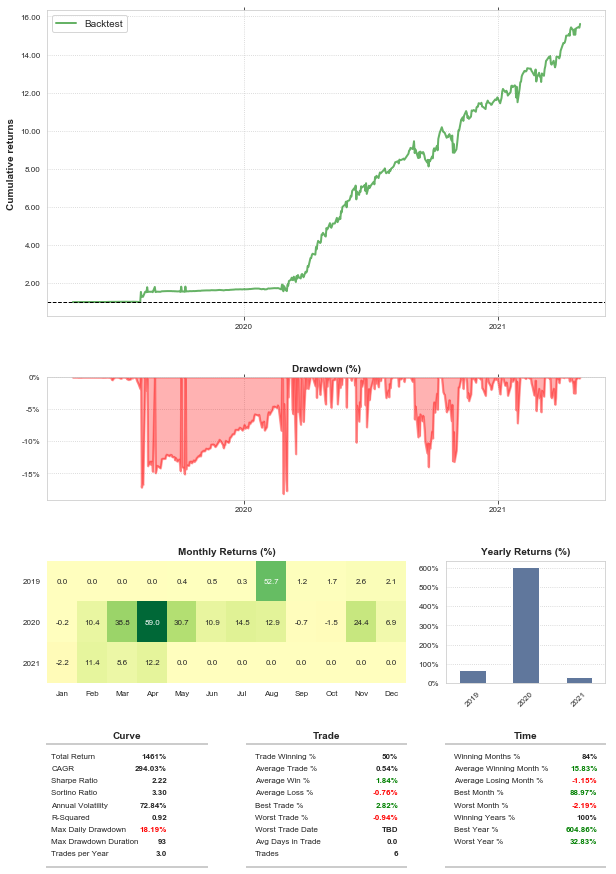

<Figure size 432x288 with 0 Axes>

In [4]:
if __name__ == '__main__':
    testing = False
    config = settings.from_file(settings.DEFAULT_CONFIG_FILENAME, testing)
    tickers = ["UPRO", "VOO"]
    filename = 'backtest_result_1'
    run(config, testing, tickers, filename)

## Kalman Filter-Based Pairs Trading without the Hidden Markov Model

In [5]:
def run(config, testing, tickers, filename):

    # Set up variables needed for backtest
    events_queue = queue.Queue()
    csv_dir = config.CSV_DATA_DIR
    initial_equity = PriceParser.parse(100000.00)

    # Use Yahoo Daily Price Handler
    # Backtest period: April 30th, 2019 to April 30th, 2021 
    start_date = datetime.datetime(2019, 4, 30)
    end_date = datetime.datetime(2021, 4, 30)
    price_handler = YahooDailyCsvBarPriceHandler(csv_dir, events_queue, tickers, \
    start_date=start_date, end_date=end_date, calc_adj_returns=True)

    # Use the Kalman Filter Pairs Trading Strategy 
    strategy = KalmanFilterPairsTradingStrategy(tickers, events_queue)

    # Use the Naive Position Sizer (suggested quantities are followed)
    position_sizer = NaivePositionSizer()

    # Use the example Risk Manger 
    risk_manager = ExampleRiskManager()

    # Use the default Portfolio Handler
    portfolio_handler = PortfolioHandler(
        initial_equity, events_queue, price_handler,
        position_sizer, risk_manager
    )

    # Use the ExampleCompliance component 
    compliance = ExampleCompliance(config)

    # Use a simulated IB Execution Handler 
    execution_handler = IBSimulatedExecutionHandler(
        events_queue, price_handler, compliance
    )

    # Use the default Statistics 
    statistics = TearsheetStatistics(
        config, portfolio_handler, title = ""
    )

    title = ['Kalman Filter-Based Pairs Trading without the Hidden Markov Model']
    backtest = TradingSession(config, strategy, tickers,
        initial_equity, start_date, end_date, events_queue, risk_manager = risk_manager, \
        price_handler = price_handler, portfolio_handler = portfolio_handler, \
            compliance = compliance, position_sizer = position_sizer, \
            execution_handler = execution_handler, statistics = statistics, \
            title = title)
    results = backtest.start_trading(testing = testing)
    statistics.save(filename)
    return results

Running Backtest...
Short: 2019-05-02 00:00:00
CLOSING SHORT: 2019-05-03 00:00:00
Short: 2019-05-07 00:00:00
CLOSING SHORT: 2019-05-08 00:00:00
Short: 2019-05-13 00:00:00
CLOSING SHORT: 2019-05-14 00:00:00
LONG: 2019-06-04 00:00:00
CLOSING LONG: 2019-06-10 00:00:00
Short: 2019-08-05 00:00:00
CLOSING SHORT: 2019-08-06 00:00:00
LONG: 2019-08-08 00:00:00
CLOSING LONG: 2019-08-09 00:00:00
Short: 2019-08-14 00:00:00
CLOSING SHORT: 2019-08-15 00:00:00
Short: 2019-08-23 00:00:00
CLOSING SHORT: 2019-08-26 00:00:00
Short: 2019-10-02 00:00:00
CLOSING SHORT: 2019-10-03 00:00:00
Short: 2019-10-08 00:00:00
CLOSING SHORT: 2019-10-09 00:00:00
Short: 2020-02-24 00:00:00
CLOSING SHORT: 2020-02-26 00:00:00
Short: 2020-02-27 00:00:00
CLOSING SHORT: 2020-02-28 00:00:00
LONG: 2020-03-02 00:00:00
CLOSING LONG: 2020-03-03 00:00:00
LONG: 2020-03-04 00:00:00
CLOSING LONG: 2020-03-05 00:00:00
Short: 2020-03-06 00:00:00
CLOSING SHORT: 2020-03-10 00:00:00
Short: 2020-03-11 00:00:00
CLOSING SHORT: 2020-03-13 00:00

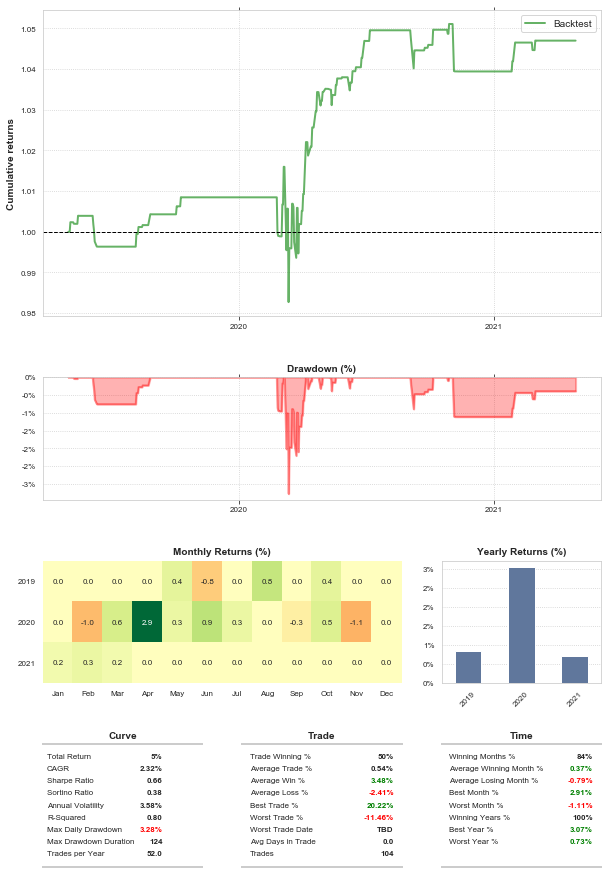

<Figure size 432x288 with 0 Axes>

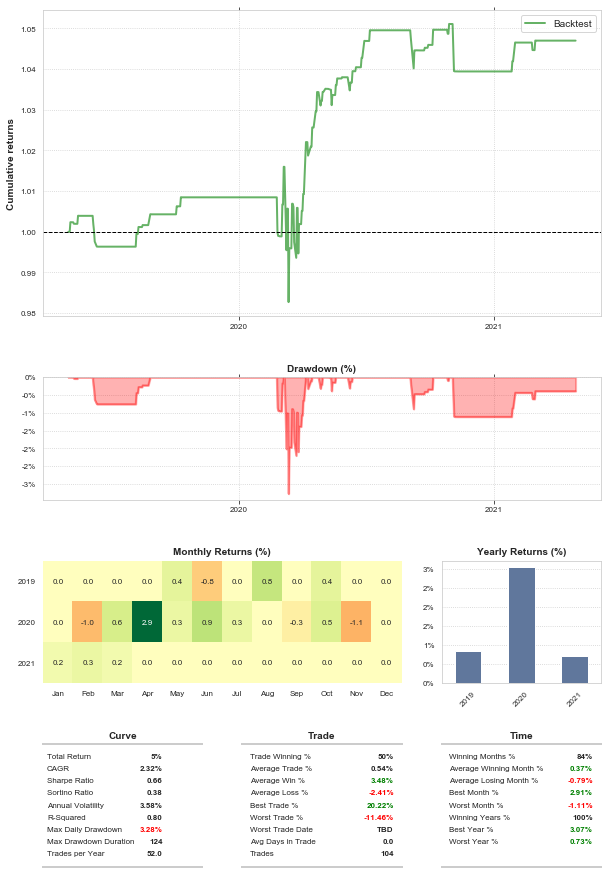

<Figure size 432x288 with 0 Axes>

In [6]:
if __name__ == '__main__':
    testing = False
    config = settings.from_file(settings.DEFAULT_CONFIG_FILENAME, testing)
    tickers = ["UPRO", "VOO"]
    filename = 'backtest_result_2'
    run(config, testing, tickers, filename)